In [17]:
import pandas as pd
import os
import torch
from transformers import Trainer, BertTokenizer
import numpy as np


os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/")

test_sentences_verbs = pd.read_csv("Datasets/nutids-r-reviewed.csv", sep="|")
no_guess_df = pd.read_csv("Datasets/no_guess_df.csv", sep=";")
no_guess_lst = list(no_guess_df["comment_text"].values)

In [18]:
correct_sentences = test_sentences_verbs["correct"].values
correct_sentences[:2]

array(['Det er ikke altid nemt at forsvare din opførsel',
       'Mange drenge interesserer sig for fodbold'], dtype=object)

---

In [19]:
os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/Datasets/")
filename = "europarl-v7.da-en.da"
with open(filename, "r", encoding="UTF-8") as file:
    lines = file.readlines()

In [20]:
correct_sentences = lines[800000:805000]
correct_sentences = [line.strip("\n") for line in correct_sentences]
correct_sentences[:2]

['Partnerlandene er bestemt bedst i stand til at vælge den mest effektive, retfærdige og gennemsigtige ressourcefordeling blandt de forskellige initiativer.',
 'I årenes løb har Kommissionen til stadighed givet flere midler til bekæmpelse af hiv/aids i alle udviklingslande og specielt i Afrika, hvor den yder bistand via budgetstøtte til partnerlande i deres bestræbelser på at tage fat på de strukturelle faktorer, der ligger til grund for hiv-epidemien, som f.eks. sundhedsreformer og krisen inden for menneskelige ressourcer i sundhedssektoren.']

---

In [21]:
os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/")

import pickle
import stanza
from tqdm import tqdm

def get_pos(x):
    with open("FineTuneModels/pos_caching.pkl", "rb") as f:
        pos_list = pickle.load(f)
    if len(pos_list) != len(x):
        pos_list = []
        pos_tagger = stanza.Pipeline("da", processors='tokenize,pos', use_gpu=True, cache_directory='./cache', tokenize_pretokenized=True, n_process=4)
        for sentence in tqdm(x):
            pos = get_pos_tags(sentence, pos_tagger)
            pos_list.append(pos)
        print(len(pos_list))
        print("Updating")
        with open("FineTuneModels/pos_caching.pkl", "wb") as f:
            pickle.dump(pos_list, f)
        print("Updated")
    else:
        print("pos_caching.pkl already exists")
    return pos_list

def get_pos_tags(sentence, pos_tagger):
    doc = pos_tagger(sentence)
    features = [word.feats if word.feats else None for sentence in doc.sentences for word in sentence.words]
    feature_dicts = turn_features_to_dicts(features)
    results = [(word.upos, [word.start_char, word.end_char], feature_dicts[i]) for sentence in doc.sentences for i, word in enumerate(sentence.words)]
    return results

def turn_features_to_dicts(features):
    feature_dicts = []
    current_tense = None
    for feature in features:
        if feature is None:
            feature_dicts.append({})
            continue
        feature_dict = {}
        current_features = feature.split("|")
        for current_feature in current_features:
            key, value = current_feature.split("=")
            if key == "Tense" and current_tense is None:
                current_tense = value
            feature_dict[key] = value
        if "Tense" not in feature_dict and "VerbForm" in feature_dict and key is not None:
            feature_dict["Tense"] = "Pres" if current_tense is None else current_tense
        feature_dicts.append(feature_dict)
    return feature_dicts

all_pos = get_pos(correct_sentences)

2023-05-24 22:33:21 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-05-24 22:33:22 INFO: Loading these models for language: da (Danish):
| Processor | Package |
-----------------------
| tokenize  | ddt     |
| pos       | ddt     |

2023-05-24 22:33:22 WARNING: GPU requested, but is not available!
2023-05-24 22:33:22 INFO: Using device: cpu
2023-05-24 22:33:22 INFO: Loading: tokenize
2023-05-24 22:33:22 INFO: Loading: pos
2023-05-24 22:33:22 INFO: Done loading processors!
100%|██████████| 5000/5000 [14:55<00:00,  5.58it/s]


5000
Updating
Updated


In [22]:
os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/Datasets/")
filename = "europarl-v7.da-en.da"
with open(filename, "r", encoding="UTF-8") as file:
    lines = file.readlines()
with open("nutids_r_bøjninger.pickle", "rb") as f:
    nutids_r_bøjninger = pickle.load(f)
with open("nutids_r_stem.pickle", "rb") as f:
    nutids_r_stem = pickle.load(f)

In [23]:
from tqdm import tqdm

testset = []
labels = []

padded_words = []

padding_left = 15
padding_right = 5

def get_pos_tags(index):
    current_pos = all_pos[index]
    return [current_pos[i][0] for i in range(len(current_pos))]

og_index = 0
no_guess_lst_index = 0
comma_right_before_index = 0

for i in tqdm(range(len(correct_sentences))):
    line = correct_sentences[i]
    if len(str(line)) < 1 or str(line) == "nan":
        continue
    line = line.strip("\n")
    true_words = line.split()
    pos = get_pos_tags(i)
    words = ["<PAD>"]*padding_left + pos + ["<PAD>"]*padding_right
    true_padded_words = ["<PAD>"]*padding_left + true_words + ["<PAD>"]*padding_right
    for i, word in enumerate(true_words):
        try: stemmed = nutids_r_stem[word]
        except: continue
        if word[-1] == "s" or words[i+padding_left] != "VERB":
            continue
        if true_words[i-1].lower().strip() == "og": 
            og_index += 1
            continue
        if words in no_guess_lst:
            no_guess_lst_index += 1
            continue
        if true_words[i-1][-1] == ",":
            comma_right_before_index += 1
            continue
        if nutids_r_bøjninger[stemmed][0] == word:
            labels.append(1)
        else:
            labels.append(0)
        testset.append(" ".join(words[i:i+padding_left+padding_right+1]))
        padded_words.append(" ".join(true_padded_words[i:i+padding_left+padding_right+1]))

100%|██████████| 5000/5000 [00:42<00:00, 116.62it/s]


In [24]:
og_index, no_guess_lst_index, comma_right_before_index

(269, 0, 150)

In [25]:
df = pd.DataFrame(zip(testset, labels), columns=["comment_text", "label"])
print("Test size: ", len(df))
print("Label distribution: ")
df["label"].value_counts()

Test size:  5860
Label distribution: 


1    3516
0    2344
Name: label, dtype: int64

In [26]:
os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/")
model_path = "FineTuneModels/models/nutidsrModel9-BERT"
model_name = "Model 9-BERT"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

def load_model(path):
    device = "mps"
    torch.device(device)
    classifier = torch.load(path, map_location=torch.device('cpu'))
    classifier.eval()
    classifier.to(device)
    return Trainer(classifier)


model = load_model(model_path)
tokenizer = BertTokenizer.from_pretrained('Maltehb/danish-bert-botxo')

def convert_dataset_to_dataloader(dataset):
    test_dataset = Dataset(dataset)
    return test_dataset

def tokenize_sentences(sentences):
    X_tokenized = tokenizer(sentences, padding=True, truncation=True)
    return X_tokenized

def get_predictions(dataloader):
    raw_predictions, _, _ = model.predict(dataloader)
    scores = torch.softmax(torch.from_numpy(raw_predictions), dim=1)
    max_scores, final_prediction = torch.max(scores, dim=1)
    final_prediction = np.argmax(raw_predictions, axis=1)
    return [(p, s) for p, s in zip(final_prediction, max_scores)]


def verbs_to_check(words, pos):
    pos = pos
    verbs = []
    for i in range(len(pos)):
        if pos[i][0] != "VERB":
            verbs.append(False)
        elif "Tense" not in pos[i][2].keys():
            verbs.append(False)
        elif pos[i][2]["Tense"] != "Pres":
            verbs.append(False)
        else:
            verbs.append(True)
    for i, bool in enumerate(verbs):
        if not bool:
            continue
        word = words[i].strip(",.!?():;")
        try: stemmed_verb = nutids_r_stem[word]
        except: verbs[i] = False; continue
    return verbs

tokenized = tokenize_sentences(testset)
dataloader = convert_dataset_to_dataloader(tokenized)
predictions = get_predictions(dataloader)

  0%|          | 0/733 [00:00<?, ?it/s]

In [27]:
true_predictions = [p for (p, s) in predictions]
true_score = [s for (p, s) in predictions]

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(labels, true_predictions)
precision = precision_score(labels, true_predictions)
recall = recall_score(labels, true_predictions)
f1 = f1_score(labels, true_predictions)

data = {
    'Evaluation Measure': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
}
df = pd.DataFrame(data)

print(df)

  Evaluation Measure     Value
0           Accuracy  0.988396
1          Precision  0.994266
2             Recall  0.986348
3           F1 Score  0.990291


Accuracy before disqualifying "og: 97.8%

Accuracy after disqualifying "og" and before "," lst: 98.2%

Accuracy final: 98.5%

Accuracy on small, high quality dataset: 99.4%

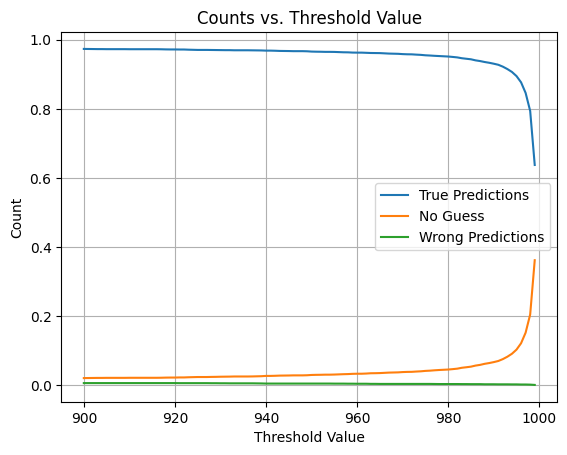

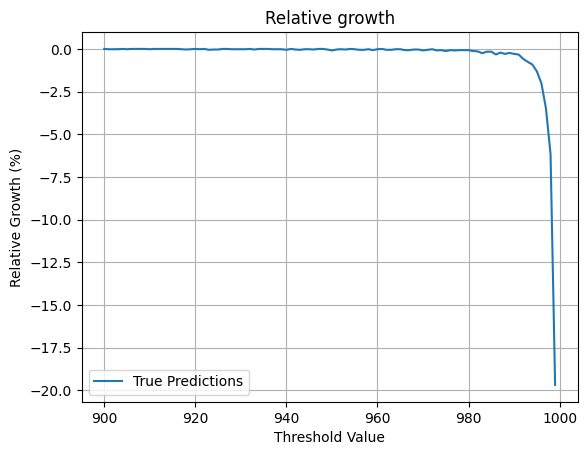

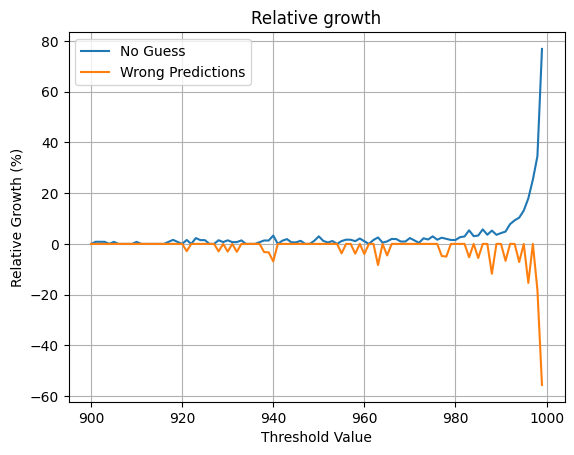

In [28]:
import matplotlib.pyplot as plt

def calculate_growth(previous, current):
    if previous == 0:
        return 0
    return (current - previous) / previous * 100

def test_cutoff(value):
    new_predictions = [p if s > value else None for (p, s) in predictions]
    true = sum([1 if p == t else 0 for (p, t) in zip(new_predictions, labels)])
    no_guess = sum([1 if p is None else 0 for p in new_predictions])
    wrong = sum([1 if p != t and p is not None else 0 for (p, t) in zip(new_predictions, labels)])
    return true/len(labels), no_guess/len(labels), wrong/len(labels)

def test_all_values():
    values = range(900, 1000)
    trues, no_guesss, wrongs = [], [], []
    for value in values:
        true, no_guess, wrong = test_cutoff(value/1000)
        trues.append(true)
        no_guesss.append(no_guess)
        wrongs.append(wrong)

    plt.plot(values, trues, label='True Predictions')
    plt.plot(values, no_guesss, label='No Guess')
    plt.plot(values, wrongs, label='Wrong Predictions')

    plt.xlabel('Threshold Value')
    plt.ylabel('Count')
    plt.title('Counts vs. Threshold Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    previous_true = 0
    previous_no_guess = 0
    previous_wrong = 0

    trues, no_guesss, wrongs = [], [], []

    for value in values:
        true, no_guess, wrong = test_cutoff(value/1000)
        true_growth = calculate_growth(previous_true, true)
        no_guess_growth = calculate_growth(previous_no_guess, no_guess)
        wrong_growth = calculate_growth(previous_wrong, wrong)

        trues.append(true_growth)
        no_guesss.append(no_guess_growth)
        wrongs.append(wrong_growth)

        previous_true = true
        previous_no_guess = no_guess
        previous_wrong = wrong

    plt.plot(values, trues, label='True Predictions')
    plt.xlabel('Threshold Value')
    plt.ylabel('Relative Growth (%)')
    plt.title('Relative growth')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(values, no_guesss, label='No Guess')
    plt.plot(values, wrongs, label='Wrong Predictions')

    plt.xlabel('Threshold Value')
    plt.ylabel('Relative Growth (%)')
    plt.title('Relative growth')
    plt.legend()
    plt.grid(True)
    plt.show()

test_all_values()
    


In [29]:
from tabulate import tabulate

table_data = [
    ("0.50", test_cutoff(0.50)),
    ("0.70", test_cutoff(0.70)),
    ("0.80", test_cutoff(0.80)),
    ("0.90", test_cutoff(0.90)),
    ("0.95", test_cutoff(0.95)),
    ("0.98", test_cutoff(0.98)),
    ("0.99", test_cutoff(0.99))
]

for i in range(len(table_data)):
    _1 = round(table_data[i][1][0]*100, 2)
    _2 = round(table_data[i][1][1]*100, 2)
    _3 = round(table_data[i][1][2]*100, 2)
    table_data[i] = (table_data[i][0], (_1, _2, _3))

# Find the highest accuracy, lowest wrong, and lowest no-guess percentages
highest_accuracy = max(table_data, key=lambda x: x[1][0])
lowest_wrong = min(table_data, key=lambda x: x[1][2])
lowest_no_guess = min(table_data, key=lambda x: x[1][1])

# Create the table
table = []
headers = ["Cutoff", "Correct (%)", "No Guess (%)", "Wrong (%)"]

for data in table_data:
    row = [data[0]] + list(data[1])
    table.append(row)

table_str = tabulate(table, headers, tablefmt="pipe")

# Print the table
print(table_str)

|   Cutoff |   Correct (%) |   No Guess (%) |   Wrong (%) |
|---------:|--------------:|---------------:|------------:|
|     0.5  |         98.84 |           0    |        1.16 |
|     0.7  |         98.53 |           0.56 |        0.9  |
|     0.8  |         98.14 |           1.14 |        0.72 |
|     0.9  |         97.35 |           2.05 |        0.6  |
|     0.95 |         96.59 |           2.95 |        0.46 |
|     0.98 |         95.15 |           4.52 |        0.32 |
|     0.99 |         93.07 |           6.67 |        0.26 |


## Error display:

In [30]:
errors_index = [True if p != t else False for (p, t) in zip(true_predictions, labels)]
errors = [padded_words[i] for i in range(len(padded_words)) if errors_index[i]]
print(*errors, sep="\n\n")

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> Derfor er den måde, EU fremmer kvinders rettigheder og ligestilling på,

<PAD> <PAD> <PAD> <PAD> <PAD> Det er blevet fastslået, at 43,7 % af de handicappede kunne arbejde, hvis de fik den

os over denne tankevækkende betænkning om dette vigtige emne, og vi vil selvfølgelig alle sammen støtte den, og vi lykønsker ordføreren.

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> På den måde vi de forsøge at forstå problemerne. <PAD> <PAD>

der helt enkelt for få virksomheder. Og en virksomhed, som ikke findes, kan heller ikke skabe arbejdspladser, så simpelt er det.

er blevet nævnt, med det formål at lade alle højtstående embedsmænd i mine egne tjenestegrene arbejde i mindst en uge i

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> Har De oplysninger, De kan give os, eller drejer det sig udelukkende om at

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> Jeg beklager, og jeg undskylder, at jeg ikke så Dem række hånden op. <PAD>

<PAD

In [112]:
stemmed = nutids_r_stem["så"]
nutids_r_bøjninger[stemmed]

['så', 'sår']